In [ ]:
#default_exp audio.model
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from local.core import *
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.optimizer import *
from local.metrics import *
from local.vision.learner import *
from local.audio.core import *
from local.notebook.showdoc import *

In [ ]:
url = URLs.ESC50_SAMPLE

In [ ]:
path = untar_data(url)

In [ ]:
items = get_audio_files(path)

In [ ]:
split_idx = RandomSplitter()(items)

In [ ]:
split_idx

((#64) [66,54,76,9,79,4,57,63,18,28...],
 (#16) [46,20,1,31,16,42,26,38,32,64...])

In [ ]:
items[0]

PosixPath('/home/kbird/.fastai/data/esc50_sample/cat/1-79113-A-5.wav')

In [ ]:
items[0]

PosixPath('/home/kbird/.fastai/data/esc50_sample/cat/1-79113-A-5.wav')

In [ ]:
mel_args = {'sample_rate': 44100, 'n_fft': 2560}

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MelSpectrogramify(**mel_args), AmplitudeToDBify()], as_item=True)

In [ ]:
pipe_audio(items[0])

tensor([[[  15.6331,   21.7171,   18.7544,  ..., -100.0000, -100.0000,
          -100.0000],
         [  11.1212,   12.3099,   15.5395,  ..., -100.0000, -100.0000,
          -100.0000],
         [   2.9383,   10.0557,    9.6219,  ..., -100.0000, -100.0000,
          -100.0000],
         ...,
         [ -58.4088,  -55.9744,  -56.2537,  ..., -100.0000, -100.0000,
          -100.0000],
         [ -58.7888,  -56.6905,  -54.8807,  ..., -100.0000, -100.0000,
          -100.0000],
         [ -56.1805,  -57.3048,  -55.9376,  ..., -100.0000, -100.0000,
          -100.0000]]])

In [ ]:
class PetAudioTfm(Transform):
    def __init__(self, items, train_idx):
        self.items,self.train_idx = items,train_idx
        self.labeller = parent_label
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return pipe_audio(o), self.o2i[self.labeller(o)]
    
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [ ]:
pets = DataBlock(types=(AudioSpectrogram, Category), 
          get_items=get_audio_files, 
          splitter=RandomSplitter(), 
          get_y=parent_label
         )

In [ ]:
dbunch = pets.databunch(path, item_tfms=pipe_audio, bs=4)

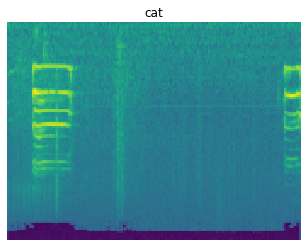

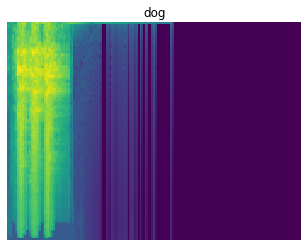

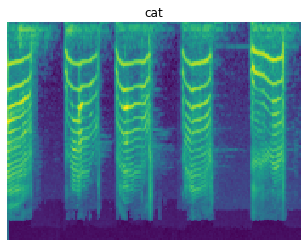

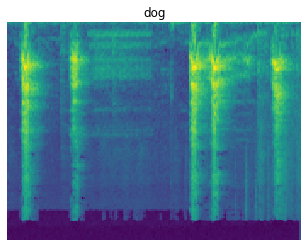

In [ ]:
dbunch.show_batch()

In [ ]:
from torch.nn import Conv2d, Sequential, Module

In [ ]:
from torchvision.models import resnet34

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=[accuracy, error_rate], path=Path("~/.fastai"))

In [ ]:
learn.model[0][0].in_channels=1

In [ ]:
learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

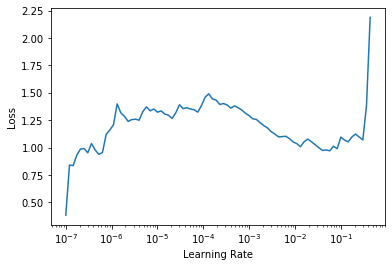

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.549394,0.556132,0.687500,0.312500,00:00
1,0.875959,0.549482,0.687500,0.312500,00:00
2,0.980389,0.464985,0.687500,0.312500,00:00
3,1.097953,0.453912,0.750000,0.250000,00:00
4,0.591208,0.502281,0.687500,0.312500,00:00


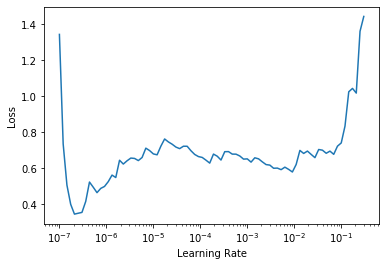

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.599578,2.001385,0.750000,0.250000,00:00
1,1.222491,1.459510,0.812500,0.187500,00:00
2,0.744710,0.356071,0.937500,0.062500,00:00
3,1.487704,0.482782,0.875000,0.125000,00:00
4,0.930410,0.167387,0.937500,0.062500,00:00


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
preds.argmax(dim=1)

tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [ ]:
targs

tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1])

In [ ]:
learn.dbunch.valid_ds[-1].show

In [ ]:
AudioSignal.create(learn.dbunch.valid_ds[-1][0]).show()